# COVID19 - District Region

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
LoadData=False

if LoadData:
    get_data.get_data()

In [3]:
dfSP = pd.read_csv("data/dados_municipios_SP.csv")
dfSP

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,DRS
0,2020-04-19,SP,TOTAL,state,14267,1015,53,True,45919049.0,35.0,31.06989,0.0711,Indefinido
1,2020-04-18,SP,TOTAL,state,13894,991,52,False,45919049.0,35.0,30.25760,0.0713,Indefinido
2,2020-04-17,SP,TOTAL,state,12841,928,51,False,45919049.0,35.0,27.96443,0.0723,Indefinido
3,2020-04-16,SP,TOTAL,state,11568,853,50,False,45919049.0,35.0,25.19216,0.0737,Indefinido
4,2020-04-15,SP,TOTAL,state,11043,778,49,False,45919049.0,35.0,24.04884,0.0705,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2020-04-14,SP,Águas de São Pedro,city,1,0,5,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3264,2020-04-13,SP,Águas de São Pedro,city,1,0,4,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3265,2020-04-12,SP,Águas de São Pedro,city,1,0,3,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3266,2020-04-11,SP,Águas de São Pedro,city,1,0,2,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba


In [4]:
# Model

In [5]:
# lista DRSs
DRS = list(dfSP["DRS"].unique())
DRS.remove("Indefinido")
DRS

['DRS 09 - Marília',
 'DRS 06 - Bauru',
 'DRS 16 - Sorocaba',
 'DRS 07 - Campinas',
 'DRS 03 - Araraquara',
 'DRS 02 - Araçatuba',
 'DRS 17 - Taubaté',
 'DRS 10 - Piracicaba',
 'DRS 01 - Grande São Paulo',
 'DRS 15 - São José do Rio Preto',
 'DRS 12 - Registro',
 'DRS 05 - Barretos',
 'DRS 13 - Ribeirão Preto',
 'DRS 11 - Presidente Prudente',
 'DRS 04 - Baixada Santista',
 'DRS 14 - São João da Boa Vista',
 'DRS 08 - Franca']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [6]:
#objective function Odeint solver
from scipy.integrate import odeint

#objective function Odeint solver
def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b, mu = point
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S+mu*S #S
        y1=(beta2*A+beta*I)*S-sigma*E-mu*E #E
        y2=sigma*E*(1-p)-gamma*A-mu*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I-mu*I#I
        y4=b*I+gamma*A+sigma2*I-mu*R #R
        y5=(-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SEAIRD,y0,tspan,hmax=0.01)

    l1=0
    l2=0
    l3=0
    tot=0

    for i in range(0,len(data.values)):
        if data.values[i]>startNCases:
            l1 = l1+(res[i,3] - data.values[i])**2
            l2 = l2+(res[i,5] - death.values[i])**2
            newRecovered=min(1e6,data.values[i]*ratioRecovered)
            l3 = l3+(res[i,4] - newRecovered)**2
            tot+=1
    l1=np.sqrt(l1/max(1,tot))
    l2=np.sqrt(l2/max(1,tot))
    l3=np.sqrt(l3/max(1,tot))
    
    #weight for cases
    u = weigthCases  #Brazil US 0.1
    w = weigthRecov
    #weight for deaths
    v = max(0,1. - u - w)
    
    return u*l1 + v*l2 + w*l3

In [7]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-15,60,280000.0,0.0001,0.0001,0.0001,0.0001,80.0000,1500,0.1,0.6,0.1
1,DRS 02 - Araçatuba,2020-04-01,60,500.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
2,DRS 03 - Araraquara,2020-04-01,60,2000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
3,DRS 04 - Baixada Santista,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
4,DRS 05 - Barretos,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
5,DRS 06 - Bauru,2020-04-01,60,10000.0,0.0001,0.0001,4.0000,0.0001,0.0001,0,0.1,0.4,0.1
6,DRS 07 - Campinas,2020-04-01,60,20000.0,0.0001,0.0001,40.0000,0.0001,0.0001,0,0.1,0.4,0.1
7,DRS 08 - Franca,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
8,DRS 09 - Marília,2020-04-01,60,5000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
9,DRS 10 - Piracicaba,2020-04-01,60,10000.0,0.0001,0.0001,0.0001,0.0001,1.0000,0,0.1,0.4,0.1


In [8]:
# Initial parameter optimization

In [13]:
# Load solver
GlobalOptimization=True
import ray

if GlobalOptimization:
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
else:
    import Learner #minimize

In [14]:
allDistricts=True

results=[]
if allDistricts:
    for districtRegion in DRS:
        query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        learner = Learner.Learner.remote(districtRegion, lossOdeint, *parameters)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    districtRegion="DRS 01 - Grande São Paulo"
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
    # learner.train()
    # add function evaluation to the queue
    results.append(learner.train.remote())

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

(pid=3798) rodando DRS 16 - Sorocaba
(pid=3792) rodando DRS 06 - Bauru
(pid=3807) rodando DRS 09 - Marília
(pid=4875) rodando DRS 03 - Araraquara
(pid=4877) rodando DRS 02 - Araçatuba
(pid=4876) rodando DRS 07 - Campinas
(pid=4885) rodando DRS 17 - Taubaté
(pid=4880) rodando DRS 10 - Piracicaba
(pid=4882) rodando DRS 15 - São José do Rio Preto
(pid=4888) rodando DRS 01 - Grande São Paulo
(pid=4881) rodando DRS 12 - Registro
(pid=4883) rodando DRS 05 - Barretos
(pid=4884) rodando DRS 14 - São João da Boa Vista
(pid=4886) rodando DRS 13 - Ribeirão Preto
(pid=4887) rodando DRS 04 - Baixada Santista
(pid=4890) rodando DRS 11 - Presidente Prudente
(pid=4892) rodando DRS 08 - Franca
(pid=4883) basinhopping step 0: f 4.49001
(pid=4877) basinhopping step 0: f 4.0353
(pid=4875) basinhopping step 0: f 3.08224
(pid=3798) basinhopping step 0: f 4.37707
(pid=4886) basinhopping step 0: f 6.44474
(pid=4881) basinhopping step 0: f 1.56437
(pid=4885) basinhopping step 0: f 5.49798
(pid=4887) basinhoppi

(pid=4877) basinhopping step 2: f 3.11097 trial_f 3.11097 accepted 1  lowest_f 3.07156
(pid=4881) basinhopping step 2: f 1.56597 trial_f 1.56597 accepted 1  lowest_f 1.56437
(pid=4881) 
(pid=4881)                          fun: array([1.56437384])
(pid=4881)  lowest_optimization_result:       fun: array([1.56437384])
(pid=4881)  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
(pid=4881)       jac: array([-2.08756656e-01, -6.26053343e-01,  1.36246570e-04, -1.12621024e-04,
(pid=4881)         3.34177130e-05,  7.00229381e+00, -1.56763491e-05,  8.17013124e-04])
(pid=4881)   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
(pid=4881)      nfev: 603
(pid=4881)       nit: 37
(pid=4881)    status: 0
(pid=4881)   success: True
(pid=4881)         x: array([4.00000000e-01, 4.00000000e-01, 1.20313930e-02, 5.07815786e-03,
(pid=4881)        2.53909125e-02, 1.00000000e-12, 1.30859500e-02, 8.15843357e-06])
(pid=4881)                     message: ['success condition satisfied']
(pid=488

(pid=4880) warning: basinhopping: local minimization failure
(pid=4880) basinhopping step 3: f 3.03218 trial_f 14.8651 accepted 0  lowest_f 3.03218
(pid=4892) basinhopping step 2: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=4892) 
(pid=4892)                          fun: array([1.17753946])
(pid=4892)  lowest_optimization_result:       fun: array([1.17753946])
(pid=4892)  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
(pid=4892)       jac: array([-1.25018884e-02, -3.77819331e-02,  4.94166930e-03,  7.64139996e-01,
(pid=4892)         7.64223174e-01, -8.51119175e-04, -6.43485265e-05,  9.17588659e+01])
(pid=4892)   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
(pid=4892)      nfev: 1080
(pid=4892)       nit: 81
(pid=4892)    status: 0
(pid=4892)   success: True
(pid=4892)         x: array([4.00000000e-01, 4.00000000e-01, 6.88554250e-03, 1.00000000e-12,
(pid=4892)        1.00000000e-12, 4.96840006e-03, 8.06683323e-05, 1.00000000e-12])
(pid=4892)        

(pid=4880) basinhopping step 5: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=4880) found new global minimum on step 5 with function value 3.03218
(pid=4884) basinhopping step 4: f 1.56366 trial_f 1.56366 accepted 1  lowest_f 1.56218
(pid=4884) 
(pid=4884)                          fun: array([1.5621835])
(pid=4884)  lowest_optimization_result:       fun: array([1.5621835])
(pid=4884)  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
(pid=4884)       jac: array([-4.31112923e-03,  3.38555850e-03, -3.52688989e-03,  3.33696668e+00,
(pid=4884)        -3.57491814e-06,  9.87099291e-04,  3.33701211e+00,  2.83410221e+03])
(pid=4884)   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
(pid=4884)      nfev: 1764
(pid=4884)       nit: 155
(pid=4884)    status: 0
(pid=4884)   success: True
(pid=4884)         x: array([2.48212965e-01, 2.34399360e-01, 3.08858428e-03, 1.00000000e-12,
(pid=4884)        2.35625234e-02, 4.38785592e-03, 1.00000000e-12, 1.00000000e-12])
(pid=4

# Plots

In [15]:
import matplotlib.pyplot as plt
import covid_plots

In [16]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [17]:
#DRS 01 - Grande São Paulo
#DRS 02 - Araçatuba
#DRS 03 - Araraquara
#DRS 04 - Baixada Santista
#DRS 05 - Barretos
#DRS 06 - Bauru
#DRS 07 - Campinas
#DRS 08 - Franca
#DRS 09 - Marília
#DRS 10 - Piracicaba
#DRS 11 - Presidente Prudente
#DRS 12 - Registro
#DRS 13 - Ribeirão Preto
#DRS 14 - São João da Boa Vista
#DRS 15 - São José do Rio Preto
#DRS 16 - Sorocaba
#DRS 17 - Taubaté

#select districts for plotting
districts4Plot=['DRS 01 - Grande São Paulo',
               'DRS 04 - Baixada Santista',
               'DRS 07 - Campinas',
               'DRS 05 - Barretos',
               'DRS 15 - São José do Rio Preto']

#main district region for analysis
districtRegion = "DRS 01 - Grande São Paulo"

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 0

#versio'n to identify the png file result
version = "1"

#parameters for plotting
query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

In [18]:
#do not allow the scrolling of the plots

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
#number of cases to start plotting model in log graph - real data = 100
startCase=1

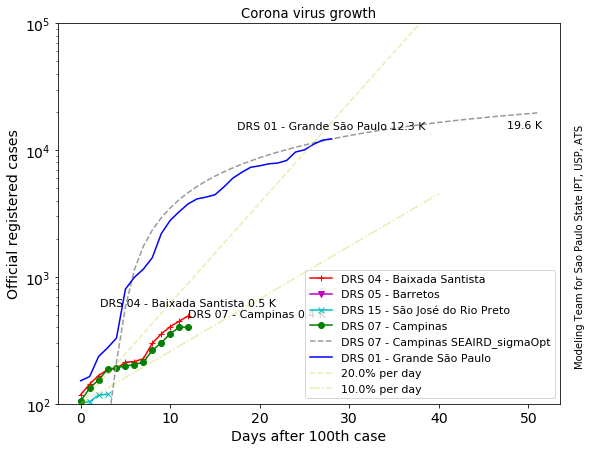

Infection speed= 5.9711479608590965
Day with the maximum infections occurred= 19
Total number of recorded infected people at the infection’s end= 14779
Errors =  [0.4871004084256057, 1.1389234118914553]


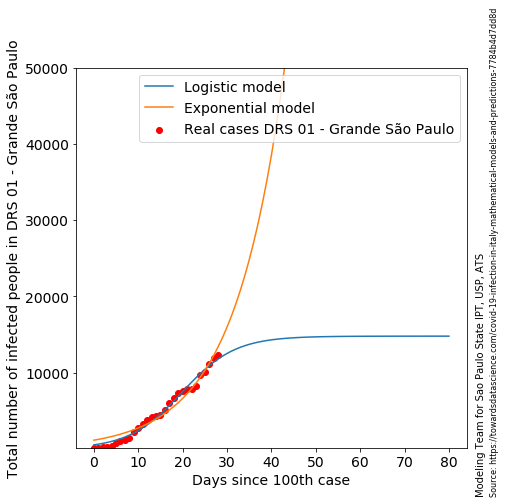

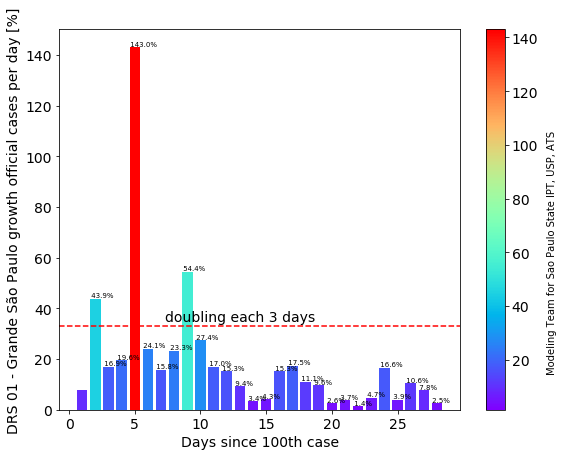

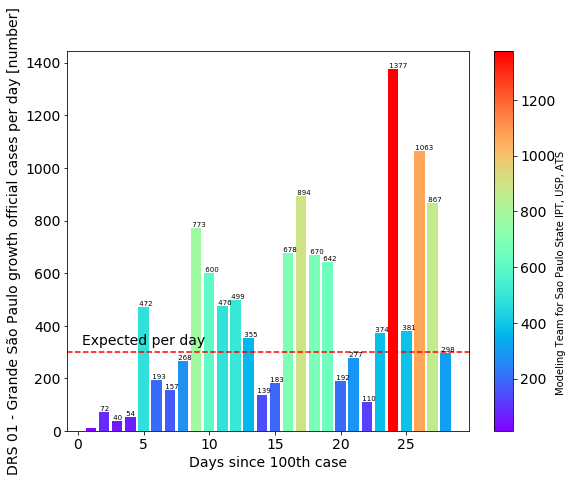

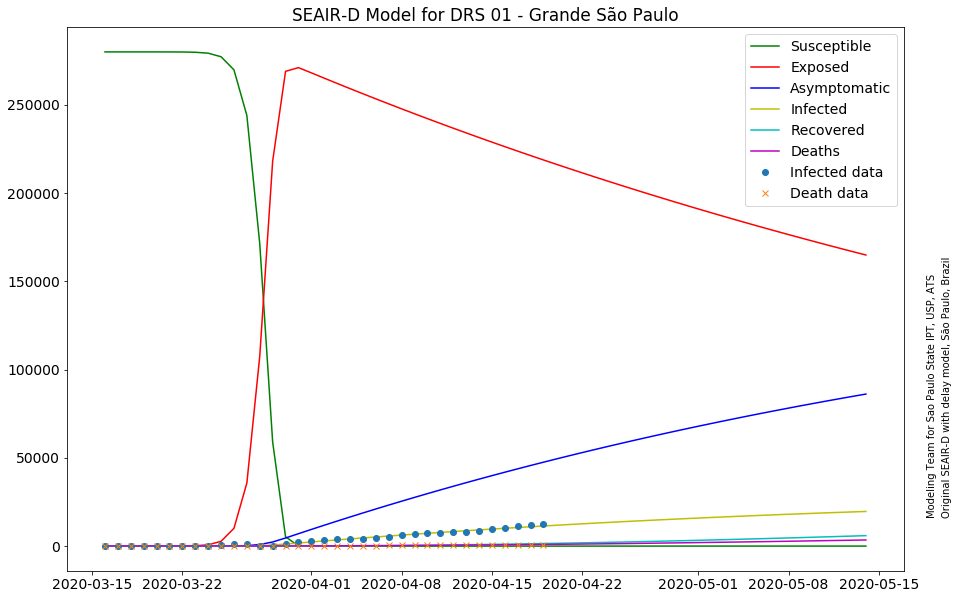

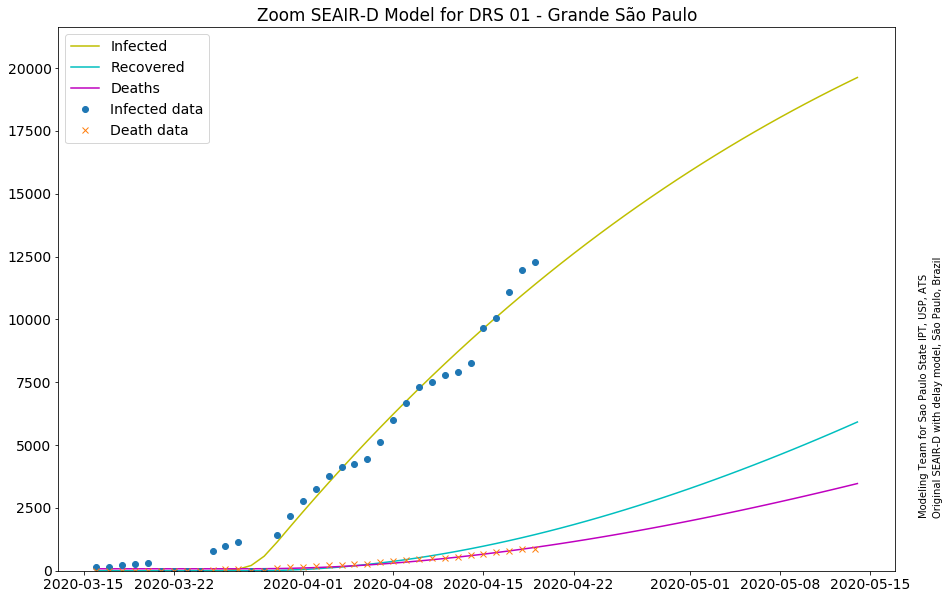

In [21]:
covid_plots.covid_plots(districtRegion, districts4Plot, startdate,predict_range, startCase, opt, version, show=True)